In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import pi, c
from scipy.fft import fft, ifft, fftshift

from decoding import get_header_dict, packet_generator_from_file, packet_generator, build_data_word_dict, index_decoder, annotation_decoder
from packet import Packet
from utils import create_bit_string, find_packet_of_type, time_packet_generation

In [2]:
file_prefix  = 'sar_data/S1A_IW_RAW__0SDV_20240806T135224_20240806T135256_055093_06B68A_AE41.SAFE/'
data_file = 's1a-iw-raw-s-vv-20240806t135224-20240806t135256-055093-06b68a.dat'
raw_data = open(file_prefix + data_file, 'rb')

In [3]:
PacketGenerator = packet_generator(raw_data)

In [4]:
packet = next(PacketGenerator)

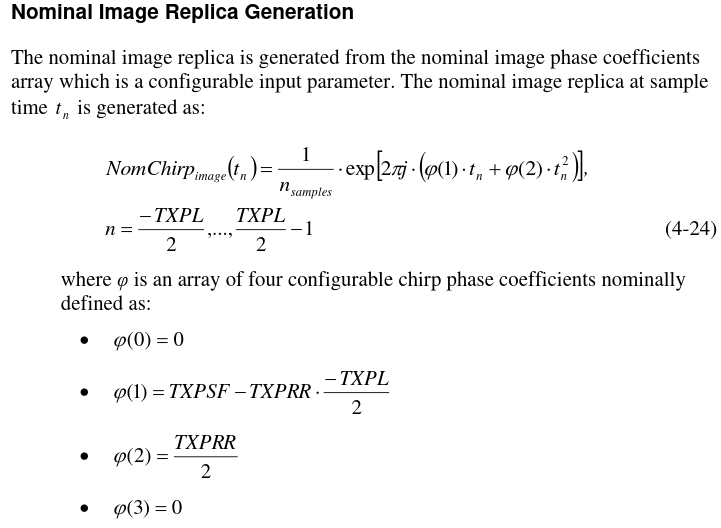

In [5]:
complex_samples, num_bytes = packet.get_complex_samples()
primary_header = packet.get_primary_header()
secondary_header = packet.get_secondary_header()
print(f'Primary Header: {primary_header}')
print(f'Secondary Header: {secondary_header}')
print(f'Complex Samples: {complex_samples}')

Primary Header: {'packet_version_number': 0, 'packet_type': 0, 'secondary_header_flag': 1, 'process_id': 65, 'process_category': 12, 'packet_sequence_count': 11157, 'packet_data_length': 18621}
Secondary Header: {'coarse_time': 1406987562, 'fine_time': 7757, 'sync_marker': 892270675, 'data_take_id': 225252800, 'ecc': 'interferomatric_wide_swath', 'test_mode': 'measurement_mode', 'rx_channel_id': 'V', 'instrument_configuration_id': 7, 'sc_data_word_index': 27, 'sc_data_word': '1011111011000011', 'space_packet_count': 240533, 'pri_count': 243384, 'error_flag': 'nominal', 'baq_mode': 'fdbaq_mode_0', 'baq_block_length': 256, 'range_decimation': 8, 'rx_gain': -4.0, 'tx_ramp_rate': np.float64(1.078230321255918), 'tx_pulse_start_frequency': np.float64(-28.251534196373175), 'pulse_length': 52.40481033595628, 'rank': 9, 'pri': 582.3674372819869, 'swst': 98.06919514319017, 'swl': 372.4284919605149, 'calibration_mode': 0, 'tx_pulse_number': 6, 'signal_type': 'echo', 'swap': 1, 'swath_number': 10,

In [6]:
txpsf = secondary_header['tx_pulse_start_frequency']
txprr = secondary_header['tx_ramp_rate']
txpl = secondary_header['pulse_length']
phi_1 = txpsf - (txprr * (-txpl / 2))
phi_2 = txprr / 2
num_samples = complex_samples.shape[0]
t = np.linspace(-0.5 * txpl, (0.5 * txpl), num_samples)
coefs = np.hamming(num_samples)
chirp = (1 / num_samples) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))

In [7]:
filtered = fftshift(ifft(fft(complex_samples) * fft(chirp * coefs)))
norm = np.abs(filtered) / np.max(np.abs(filtered))

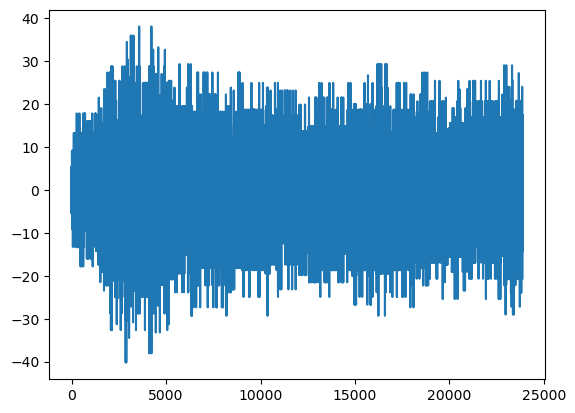

In [8]:
plt.plot(complex_samples.real)

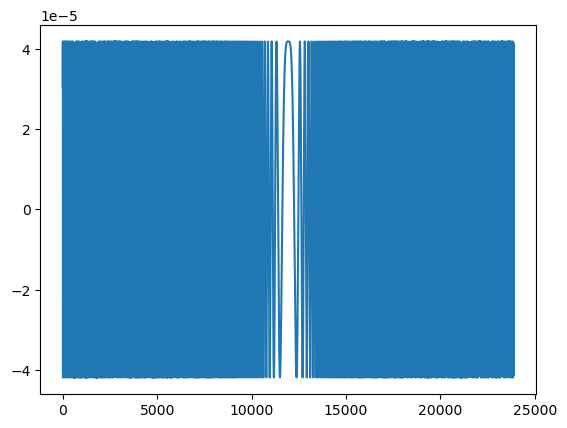

In [9]:
plt.plot(chirp.real)

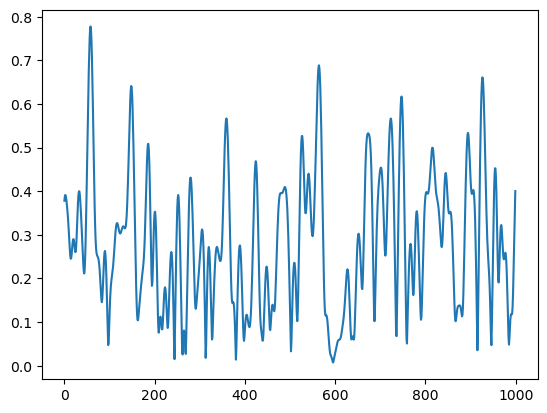

In [10]:
plt.plot(norm[0:1000])